# Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input,Dropout, Activation,Concatenate
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

# Prepare Generators and Variables Initialization

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


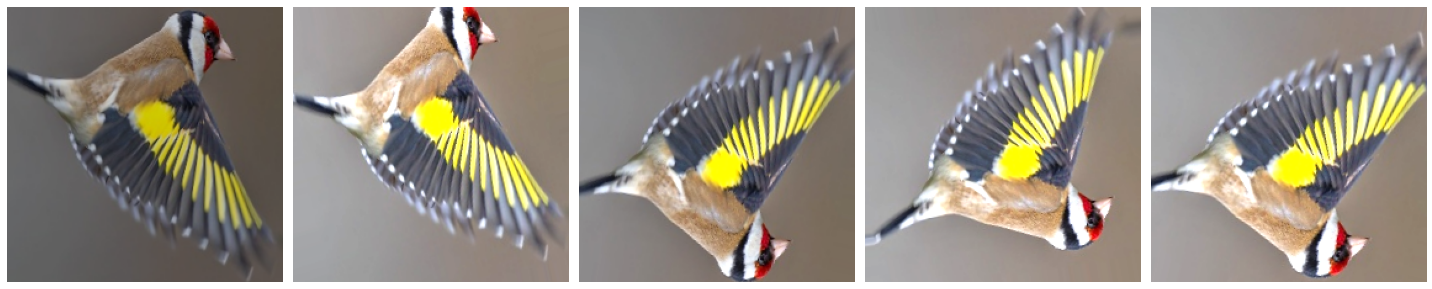

In [2]:

train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.5, 1.5],
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
    )

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
    )

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Build model and train model

In [3]:
base_mobilenet = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_mobilenet.layers:
  # freeze layers
  layer.trainable = False

# base_mobilenet.trainable = False
base_mobilenet.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-07 13:17:17.824703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-07 13:17:17.824802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [4]:
new_model = Sequential()
new_model.add(base_mobilenet)

new_model.add(Flatten()) 
new_model.add(Activation('relu'))
new_model.add(Dense(nr_birds)) 
new_model.add(Activation('softmax'))

# print the new_model summary
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 activation (Activation)     (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 20)                1003540   
                                                                 
 activation_1 (Activation)   (None, 20)                0         
                                                                 
Total params: 4,232,404
Trainable params: 1,003,540
Non-trainable params: 3,228,864
______________________________________

In [5]:
new_model.compile(SGD(lr=0.001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [6]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

checkpointer = ModelCheckpoint(filepath='./checkpoints/mobile_net_birds.model.h5', save_best_only=True)

history = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.0001, verbose=1)])

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_37782/3031277600.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.0001, verbose=1)])


Epoch 1/30


2022-05-07 13:17:18.747833: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-07 13:17:19.415314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 3.1301 - accuracy: 0.7073

2022-05-07 13:17:41.146640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 23s 231ms/step - loss: 3.1301 - accuracy: 0.7073 - val_loss: 0.6868 - val_accuracy: 0.9000
Epoch 2/30
96/96 [==============================] - 23s 241ms/step - loss: 0.7823 - accuracy: 0.8987 - val_loss: 0.2535 - val_accuracy: 0.9400
Epoch 3/30
96/96 [==============================] - 27s 283ms/step - loss: 0.5527 - accuracy: 0.9257 - val_loss: 0.3314 - val_accuracy: 0.9600
Epoch 4/30
96/96 [==============================] - 36s 376ms/step - loss: 0.3843 - accuracy: 0.9471 - val_loss: 0.3935 - val_accuracy: 0.9300
Epoch 5/30
96/96 [==============================] - 53s 556ms/step - loss: 0.3255 - accuracy: 0.9549 - val_loss: 0.2073 - val_accuracy: 0.9500
Epoch 6/30
96/96 [==============================] - 60s 624ms/step - loss: 0.2985 - accuracy: 0.9589 - val_loss: 0.0681 - val_accuracy: 0.9800
Epoch 7/30
96/96 [==============================] - 56s 577ms/step - loss: 0.2413 - accuracy: 0.9635 - val_loss: 0.4663 - val_accuracy: 0.9600
Epoch 8/30

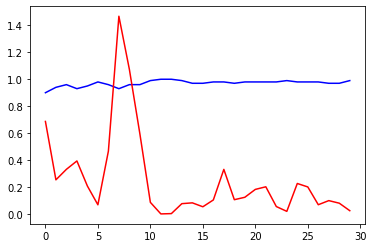

In [7]:
plt.plot(history.history['val_accuracy'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.show()

# Testing

In [8]:
test_loss, test_acc = new_model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

4/4 [==============================] - 1s 133ms/step - loss: 0.2752 - accuracy: 0.9800
Test Accuracy: 0.9799999594688416


In [9]:
new_model.save('./models/mobile_net.h5')

## Running Predictions From Saved Model

In [10]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(sorted(os.listdir(train_path))))
  print(all_birds_cat)
  for i, pred in enumerate(predicted_arr):
    print(np.argmax(pred))
    return all_birds_cat[np.argmax(pred)]


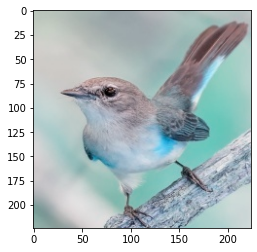

2022-05-07 13:43:47.391071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[7.2373737e-08 1.1819713e-08 8.5440891e-14 1.7037848e-10 1.6798898e-06
  2.1818285e-15 5.0585154e-09 5.9861671e-16 1.6313250e-03 2.2656709e-04
  4.8407540e-01 1.6224380e-05 2.7541416e-09 1.1066336e-20 1.1686291e-14
  1.6590848e-03 1.8952375e-04 2.4001357e-31 3.9399944e-20 5.1220012e-01]]
['AMERICAN REDSTART' 'BARRED PUFFBIRD' 'BELTED KINGFISHER'
 'CAPE MAY WARBLER' 'CREAM COLORED WOODPECKER' 'CRESTED CARACARA'
 'EASTERN MEADOWLARK' 'EASTERN TOWEE' 'EUROPEAN GOLDFINCH' 'HOATZIN'
 'HOOPOES' 'IBERIAN MAGPIE' 'IMPERIAL SHAQ' 'KOOKABURRA'
 'RED BELLIED PITTA' 'RUFUOS MOTMOT' 'TAIWAN MAGPIE' 'TREE SWALLOW'
 'VIOLET GREEN SWALLOW' 'WHITE TAILED TROPIC']
19
WHITE TAILED TROPIC


In [11]:

model = load_model('./models/mobile_net.h5')

predict_image_path = './dataset/20valid/AMERICAN REDSTART/1.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

predictions = new_model.predict(img)
print(predictions)
label = decode(predictions)

print(label)

# Resources

Architectures images from [Deep Learning for Vision Systems Book](https://www.manning.com/books/deep-learning-for-vision-systems)